In [2]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\leogo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
from bs4 import BeautifulSoup
import requests
import math
from dateutil import parser
import html
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait,Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException,NoSuchElementException
from selenium.webdriver.common.action_chains import ActionChains
import random
from datetime import datetime
import re
import time
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from src.api.models import *

In [8]:
import json
from sklearn.feature_extraction.text import CountVectorizer
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy

In [9]:
import json
from sklearn.feature_extraction.text import TfidfVectorizer

def getOccurences(input_text):
    nlp = spacy.load("fr_core_news_sm")
    stop_words = stopwords.words('french') + stopwords.words('english')
    stop_words.extend(["être", "avoir", "faire", "aller", "pouvoir", "savoir", "devoir", "venir"])
    # french_stop_words.extend(["être", "avoir", "faire", "aller", "pouvoir", "savoir", "devoir", "venir","ête"])
    # Create TfidfVectorizer instance
    vectorizer = TfidfVectorizer(
        token_pattern=r'\b[^\d\W]+\b'
    )

    # Tokenize and transform the input text
    X = vectorizer.fit_transform([input_text])

    # Get feature names (lemmatized tokens)
    feature_names = vectorizer.get_feature_names_out()

    # Calculate TF-IDF for each term
    tfidf_values = X.sum(axis=0).A.flatten()

    lemmatized = [token.lemma_ for token in nlp(' '.join(feature_names)) if len(token.lemma_) > 1]
    stopwords_free = [word for word in lemmatized if word not in stop_words]
    # Convert token occurrences to a dictionary
    result_dict = {token: tfidf for token, tfidf in zip(stopwords_free, tfidf_values)}

    # Convert the dictionary to a stringified JSON
    json_string = json.dumps(result_dict, separators=(',', ':'), ensure_ascii=False)

    return json_string


In [4]:
def getCleanText(text):
    infos = [item.replace("\n"," ").strip() for item in text]
    infos = [re.sub(r'\s+', ' ',item) for item in infos]
    infos = " ".join([item for item in infos if item != ''])
    return infos

In [5]:
def scrapCorpus(sources,keyword,nb_docs):

    source = ""
    position = ""
    company = ""
    workplace = ""
    published_date = ""
    contract_type = ""
    long_infos = ""


    if  "emploi-territorial" in sources:
        pages = math.ceil(nb_docs/20)
        source = "emploi-territorial"
        rootLink = "https://www.emploi-territorial.fr"
        # 20 offres par pages
        # pages = math.ceil(nb_docs/20)
        url = f"{rootLink}/emploi-mobilite/?adv-search={keyword}&page={pages}"
        response = requests.get(url) 
        soup = BeautifulSoup(response.content, 'html.parser')
        root = soup.find("body")
        offresLinkElems = root.select("div[class*='bloc-lien-offre'] > a[class*='lien-details-offre']")[:nb_docs]    
        links = [rootLink+offresLinkElem.get("href") for offresLinkElem in offresLinkElems]

        corpus = list(dict())

        for link in links:
            response = requests.get(link)
            soup = BeautifulSoup(response.content, 'html.parser')
            
            root = soup.find("body")

            position = root.select("h2[class*='set-line-emploi']")[0].text.strip()
            company = root.select("div[class*='offre-item-value'] > strong > a")[0].text.strip() if root.select("div[class*='offre-item-value'] > strong > a") else "NULL"
            workplace = root.select_one("div[class*='offre-item-label']:contains('Lieu de travail') + .offre-item-value").text.strip() if root.select_one("div[class*='offre-item-label']:contains('Lieu de travail') + .offre-item-value") else "NULL"
            published_date = root.select_one("div[class*='px-3']:contains('Publiée le') > .set-color-green").text.strip() if root.select_one("div[class*='px-3']:contains('Publiée le') > .set-color-green") else "NULL"
            contract_type = root.select_one('div[class*="offre-item-label"]:contains("Type d\'emploi") + .offre-item-value').text.strip() if root.select_one('div[class*="offre-item-label"]:contains("Type d\'emploi") + .offre-item-value') else "NULL"
            position_type = root.select_one('div[class*="offre-item-label"]:contains("Famille de métiers") + .offre-item-value').text.split(">")[0].strip()
            
            long_infos = root.select('div[class*="offre-item-text"]')

            long_infos = getCleanText([item.text for item in long_infos])
            long_infos = getOccurences(long_infos)
            current_offer = {"source": source, "link": rootLink, "position": position, "position_type": position_type,
                "company": company, "workplace": workplace, "published_date": published_date,
                "contract_type": contract_type, "description": long_infos}

            # Check if the offer is already in the corpus based on a frozenset comparison
            corpus.append(current_offer)
    
    if "apec" in sources:
        pages = math.ceil(nb_docs/20)
        source = "apec"
        service = ChromeService("C:/Users/leogo/Documents/chromedriver-win64/chromedriver-win64/chromedriver.exe")
        driver = webdriver.Chrome(service=service)
        rootLink = "https://www.apec.fr"
        try:
            for page in range(pages):    
                try:
                    driver.get(f'{rootLink}/candidat/recherche-emploi.html/emploi?motsCles={keyword}&page={pages}')
                    # Initial find of elements
                    try:
                        deny_cookies_button = WebDriverWait(driver, 10).until(
                            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button#onetrust-reject-all-handler'))
                        )

                        deny_cookies_button.click()
                    except TimeoutException:
                        pass

                    driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "div.card-offer"))
                    )

                    # Getting docs left if last page to query
                    if nb_docs%20 != 0 and page==pages-1: 
                        limit = nb_docs%20
                        div_elements_to_click_list = driver.find_elements(By.CSS_SELECTOR, 'div.card-offer')[:limit]
                    else :
                        div_elements_to_click_list = driver.find_elements(By.CSS_SELECTOR, 'div.card-offer')
                        
                    for index in range(len(div_elements_to_click_list)):
                        try:
                            WebDriverWait(driver, 10).until(
                                EC.presence_of_element_located((By.CSS_SELECTOR, "div.card-offer"))
                            )
                            # Re-find elements after navigating back
                            div_elements_to_click_list = driver.find_elements(By.CSS_SELECTOR, 'div.card-offer')

                            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                            WebDriverWait(driver, 10).until(
                                EC.presence_of_element_located((By.CSS_SELECTOR, "div.card-offer"))
                            )
                            # Check if the index is within the valid range

                            div_elements_to_click = div_elements_to_click_list[index]
                            company = div_elements_to_click.find_element(By.CSS_SELECTOR, 'p.card-offer__company').text
                            contract_type = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[0].text
                            workplace = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[1].text
                            published_date = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[2].text
                            # Scroll into view

                            actions = ActionChains(driver)
                            actions.move_to_element(div_elements_to_click).click().perform()

                            # Wait for the child element to become present in the DOM
                            WebDriverWait(driver, 20).until(
                                EC.presence_of_element_located((By.XPATH, f"//h4[text()='Descriptif du poste']"))
                            )
                            # Get the page source after the click
                            page_source = driver.page_source

                            # Use Beautiful Soup to parse the page source
                            soup = BeautifulSoup(page_source, 'html.parser')

                            # Example: Retrieve the text of a specific element
                            desc = soup.select("h4:contains('Descriptif du poste') + p")
                            descText = [" ".join(elem.text) for elem in desc][0]

                            profile = soup.select("h4:contains('Profil recherché') + p")
                            profileText = [" ".join(elem.text) for elem in profile][0]                  

                            position = soup.select_one("h4:contains('Métier') + span").text
                            position_type = soup.select_one('h4:contains("Secteur d’activité du poste")+span').text
                            long_infos = " ".join([descText,profileText])
                            long_infos = getCleanText(long_infos)
                            long_infos = getOccurences(long_infos)
                            corpus.append({"source":source,"link":rootLink,"position":position,"position_type":position_type,"company":company,"workplace":workplace,"published_date":published_date,"contract_type":contract_type,"description":long_infos})
                        except Exception as e:
                            # Print the exception for debugging purposes
                            print(f"Error: {e}")

                        finally:
                            # Navigate back to the main page
                            driver.execute_script("window.history.go(-1);")

                except Exception as e:
                    # Print the exception for debugging purposes
                    print(f"Error: {e}")

        finally:
            driver.quit()
    if "hellowork" in sources:
        pages = math.ceil(nb_docs/30)
        source = "hellowork"
        rootLink = "https://www.hellowork.com"
        service = ChromeService("C:/Users/leogo/Documents/chromedriver-win64/chromedriver-win64/chromedriver.exe")
        driver = webdriver.Chrome(service=service) 
        try:
            for page in range(pages):    
                try:
                    print(page)
                    driver.get(f'{rootLink}/fr-fr/emploi/recherche.html?k={keyword}&k_autocomplete=&l=France&l_autocomplete=&p={page+1}')
                    # Initial find of elements
                    try:
                        accept_cookies_button = WebDriverWait(driver, 10).until(
                            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button#hw-cc-notice-accept-btn'))
                        )

                        accept_cookies_button.click()

                        combobox = WebDriverWait(driver, 10).until(
                            EC.element_to_be_clickable((By.CSS_SELECTOR, "select[name='country']"))
                        )

                        select = Select(combobox)
                        # Select a specific item by visible text
                        select.select_by_value("FR")

                        form = driver.find_element(By.CSS_SELECTOR,"form[data-action*='service-adaptation']")
                        next_button = form.find_element(By.CSS_SELECTOR,"button")
                        next_button.click()
                    except TimeoutException:
                        pass

                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "button[data-cy='seeOffer']"))
                    )
                    # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                    # Getting docs left if last page to query
                    if nb_docs%20 != 0 and page==pages-1: 
                        limit = nb_docs%20
                        div_elements_to_click_list = driver.find_elements(By.CSS_SELECTOR, "button[data-cy='seeOffer']")[:limit]
                    else :
                        div_elements_to_click_list = driver.find_elements(By.CSS_SELECTOR, "button[data-cy='seeOffer']")
                        
                    for index in range(len(div_elements_to_click_list)):
                        try:
                            WebDriverWait(driver, 10).until(
                                EC.presence_of_element_located((By.CSS_SELECTOR, "button[data-cy='seeOffer']"))
                            )

                            # Re-find elements after navigating back
                            div_elements_to_click_list = driver.find_elements(By.CSS_SELECTOR, "button[data-cy='seeOffer']")
                            # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                            # driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
                            WebDriverWait(driver, 10).until(
                                EC.presence_of_element_located((By.CSS_SELECTOR, "button[data-cy='seeOffer']"))
                            )
                            # Check if the index is within the valid range

                            div_elements_to_click = div_elements_to_click_list[index]
                            # driver.execute_script("arguments[0].scrollIntoView(true);", div_elements_to_click)
                            # company = div_elements_to_click.find_element(By.CSS_SELECTOR, 'p.card-offer__company').text
                            # contract_type = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[0].text
                            # workplace = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[1].text
                            # published_date = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[2].text
                            # Scroll into view

                            # actions = ActionChains(driver)
                            # actions.move_to_element(div_elements_to_click).click().perform()
                            #On remote de deux niveau du bouton "Voir offre" pour pouvoir récupérer les informations appropriées
                            div_offer = driver.execute_script("return arguments[0].parentNode.parentNode;", div_elements_to_click)
                            company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
                            company = company_elem.find_element(By.CSS_SELECTOR, "span").text
                            company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
                            contract_type = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='contract']").text
                            workplace = div_offer.find_elements(By.CSS_SELECTOR, "div[data-cy='loc']")[-1].text
                            published_date = div_offer.find_elements(By.CSS_SELECTOR, "span[data-cy='publishDate']")[-1].text

                            driver.execute_script("arguments[0].click();", div_elements_to_click)

                            # Wait for the child element to become present in the DOM
                            WebDriverWait(driver, 20).until(
                                EC.presence_of_element_located((By.CSS_SELECTOR, "span[data-cy='jobTitle']"))
                            )
                            # Get the page source after the click
                            page_source = driver.page_source

                            # Use Beautiful Soup to parse the page source
                            soup = BeautifulSoup(page_source, 'html.parser')

                            # Example: Retrieve the text of a specific element
                            # desc = soup.select("h4:contains('Descriptif du poste') + p")
                            # descText = ["".join(elem.text) for elem in desc][0]

                            # profile = soup.select("h4:contains('Profil recherché') + p")
                            # profileText = ["".join(elem.text) for elem in profile][0]                  

                            position = soup.select_one("span[data-cy='jobTitle']").text
                            # position_type = soup.select_one('h4:contains("Secteur d’activité du poste")+span').text
                            long_infos = soup.select("section")
                            long_infos = getCleanText([item.text for item in long_infos])
                            long_infos = getOccurences(long_infos)
                            # infos = [item for item in infos if '' not in item]
                            corpus.append({"source":source,"link":rootLink,"position":position,"position_type":"NULL","company":company,"workplace":workplace,"published_date":published_date,"contract_type":contract_type,"description":long_infos})
                        except Exception as e:
                            # Print the exception for debugging purposes
                            print(f"Error: {e}")

                        finally:
                            # Navigate back to the main page
                            driver.execute_script("window.history.go(-1);")

                except Exception as e:
                    # Print the exception for debugging purposes
                    print(f"Error: {e}")
        finally:
            driver.quit()
 
    if "welcometothejungle" in sources:
        source = "welcometothejungle"
        rootLink = "https://www.welcometothejungle.com"
        service = ChromeService("C:/Users/leogo/Documents/chromedriver-win64/chromedriver-win64/chromedriver.exe")
        driver = webdriver.Chrome(service=service)
        try:
            for page in range(1,pages+1):    
                try:
                    driver.get(f'{rootLink}/fr/jobs?query=data&aroundQuery=France&page={page}')
                    # Initial find of elements
                    try:
                        accept_cookies_button = WebDriverWait(driver, 10).until(
                            EC.element_to_be_clickable((By.CSS_SELECTOR, 'button#axeptio_btn_acceptAll'))
                        )

                        accept_cookies_button.click()
                    except TimeoutException:
                        pass
                        
                    offers = WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "ol[data-testid='search-results']"))
                    )
                    
                    # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                    # Getting docs left if last page to query
                    if nb_docs%30 != 0 and page==pages: 
                        limit = nb_docs%30
                        div_elements_to_click_list = offers.find_elements(By.CSS_SELECTOR, "li")[:limit]
                    else :
                        div_elements_to_click_list = offers.find_elements(By.CSS_SELECTOR, "li")

                    for index in range(len(div_elements_to_click_list)):
                        try:
                            offers = WebDriverWait(driver, 10).until(
                                EC.presence_of_element_located((By.CSS_SELECTOR, "ol[data-testid='search-results']"))
                            )
                            
                            div_elements_to_click_list = offers.find_elements(By.CSS_SELECTOR, "li")
                            div_elements_to_click = div_elements_to_click_list[index]
                            # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                            # driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
                            # Check if the index is within the valid range
                            div_offer = div_elements_to_click.find_element(By.CSS_SELECTOR,"div")

                            position_elem = div_offer.find_element(By.CSS_SELECTOR,"h4")
                            position = position_elem.text
                            workplace = position_elem.find_elements(By.XPATH, "./following::*//span")[1].text
                            contract_type_icon = div_offer.find_element(By.CSS_SELECTOR,"i[name='contract']")
                            main_contract_div = driver.execute_script("return arguments[0].parentNode;", contract_type_icon)
                            contract_type = main_contract_div.find_element(By.CSS_SELECTOR,"span").text
                            published_date = div_offer.find_element(By.CSS_SELECTOR,"time").get_attribute("datetime").split("T")[0]
                            published_date = datetime.strptime(published_date, '%Y-%m-%d')
                            published_date = published_date.strftime('%d/%m/%Y')
                            # driver.execute_script("arguments[0].scrollIntoView(true);", div_elements_to_click)
                            # company = div_elements_to_click.find_element(By.CSS_SELECTOR, 'p.card-offer__company').text
                            # contract_type = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[0].text
                            # workplace = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[1].text
                            # published_date = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[2].text
                            # Scroll into view
                            # actions = ActionChains(driver)
                            # actions.move_to_element(div_elements_to_click).click().perform()
                            #On remote de deux niveau du bouton "Voir offre" pour pouvoir récupérer les informations appropriées
                            # div_offer = driver.execute_script("return arguments[0].parentNode.parentNode;", div_elements_to_click)
                            # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
                            # company = company_elem.find_element(By.CSS_SELECTOR, "span").text
                            # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
                            # contract_type = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='contract']").text
                            # workplace = div_offer.find_elements(By.CSS_SELECTOR, "div[data-cy='loc']")[-1].text
                            # published_date = div_offer.find_elements(By.CSS_SELECTOR, "span[data-cy='publishDate']")[-1].text

                            driver.execute_script("arguments[0].click();", div_offer)
                            WebDriverWait(driver, 20).until(
                                EC.presence_of_element_located((By.CSS_SELECTOR, "div[data-testid='job-section-description']"))
                            )
                            description_elem = driver.find_element(By.CSS_SELECTOR,"div[data-testid='job-section-description']")

                            # driver.execute_script("arguments[0].click();",description_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))
                            
                            WebDriverWait(driver, 3)

                            try:
                                profile_elem = driver.find_element(By.CSS_SELECTOR, "div[data-testid='job-section-experience']")
                                profile_html = profile_elem.find_elements(By.CSS_SELECTOR, "div")[-2].get_attribute("innerHTML")
                                profile = BeautifulSoup(profile_html, 'html.parser').get_text()
                            except NoSuchElementException:
                                # If profile element is not found, set it to "NULL"
                                profile = "NULL"
                            # driver.execute_script("arguments[0].click();",profile_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))

                            description = description_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
                            # profile = profile_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
                            
                            #parsing tags
                            description = BeautifulSoup(description, 'html.parser').get_text()
                            company_elem = driver.find_element(By.CSS_SELECTOR,"a[href*='/fr/companies/']")
                            company = company_elem.find_element(By.CSS_SELECTOR,"img").get_attribute("alt")
                            long_infos = "".join([description,profile]) if profile != "NULL" else description
                            long_infos = getCleanText([item for item in long_infos.split()])
                            long_infos = getOccurences(long_infos)

                            # print(long_infos)
                            # Wait for the child element to become present in the DOM

                            # # Get the page source after the click
                            # page_source = driver.page_source

                            # Use Beautiful Soup to parse the page source
                            # soup = BeautifulSoup(page_source, 'html.parser')

                            # Example: Retrieve the text of a specific element
                            # desc = soup.select("h4:contains('Descriptif du poste') + p")
                            # descText = ["".join(elem.text) for elem in desc][0]

                            # profile = soup.select("h4:contains('Profil recherché') + p")
                            # profileText = ["".join(elem.text) for elem in profile][0]                  

                            # position = soup.select_one("span[data-cy='jobTitle']").text
                            # position_type = soup.select_one('h4:contains("Secteur d’activité du poste")+span').text
                            # long_infos = soup.select("section")
                            # infos = [item.text.replace("\n"," ").strip() for item in long_infos]
                            # infos = [re.sub(r'\s+', ' ',item) for item in infos]
                            # infos = " ".join([item for item in infos if item != ''])
                            # infos = [item for item in infos if '' not in item]
                            corpus.append({"source":source,"link":rootLink,"position":position,"position_type":"NULL","company":company,"workplace":workplace,"published_date":published_date,"contract_type":contract_type,"description":long_infos})
                        except Exception as e:
                            # Print the exception for debugging purposes
                            print(f"Error: {e}")

                        finally:
                            # Navigate back to the main page
                            driver.execute_script("window.history.go(-1);")

                except Exception as e:
                    # Print the exception for debugging purposes
                    print(f"Error: {e}")
        finally:
            driver.quit()

    return(corpus)


In [10]:
corpus = scrapCorpus(sources=["emploi-territorial","hellowork","welcometothejungle"],keyword="data",nb_docs=3)

0


In [11]:
dict(sorted(json.loads([item["description"] for item in corpus][4]).items(), key=lambda item: item[1],reverse=True))

{'goût': 0.41173082679723416,
 'décision': 0.2413594501914821,
 'métier': 0.2413594501914821,
 'nouseuro': 0.2129642207571901,
 'nancy': 0.1987666060400441,
 'dédier': 0.18456899132289808,
 'axer': 0.17037137660575208,
 'poste': 0.14197614717146007,
 'droit': 0.12777853245431406,
 'extension': 0.11358091773716805,
 'niveau': 0.11358091773716805,
 'engineer': 0.09938330302002205,
 'dès': 0.08518568830287604,
 'entiter': 0.08518568830287604,
 'mener': 0.08518568830287604,
 'prédictif': 0.08518568830287604,
 'sein': 0.08518568830287604,
 'lab': 0.07098807358573003,
 'plan': 0.07098807358573003,
 'possible': 0.07098807358573003,
 'souhaiter': 0.07098807358573003,
 'business': 0.056790458868584026,
 'conduire': 0.056790458868584026,
 'euro': 0.056790458868584026,
 'fixe': 0.056790458868584026,
 'gestion': 0.056790458868584026,
 'retraire': 0.056790458868584026,
 'verser': 0.056790458868584026,
 'bon': 0.04259284415143802,
 'groupe': 0.04259284415143802,
 'python': 0.04259284415143802,
 'sps

In [11]:
corpus

[{'source': 'emploi-territorial',
  'link': 'https://www.emploi-territorial.fr',
  'position': 'Ingénieur data F/H',
  'position_type': "Informatique et système d'information",
  'company': 'CONSEIL DEPARTEMENTAL DU NORD',
  'workplace': 'Lille cedex',
  'published_date': '19/12/2023',
  'contract_type': "Emploi permanent - création d'emploi",
  'description': '{"accompagner":0.014418370325306892,"accès":0.014418370325306892,"accéder":0.007209185162653446,"acteur":0.007209185162653446,"action":0.007209185162653446,"activemer":0.007209185162653446,"activité":0.007209185162653446,"administratif":0.007209185162653446,"aider":0.007209185162653446,"aisance":0.007209185162653446,"analyse":0.007209185162653446,"analyser":0.007209185162653446,"analyste":0.007209185162653446,"anime":0.007209185162653446,"animer":0.007209185162653446,"appel":0.007209185162653446,"application":0.028836740650613785,"apply":0.007209185162653446,"apporter":0.007209185162653446,"approprier":0.007209185162653446,"appu

In [20]:
len(corpus)

60

In [22]:
from sqlalchemy import create_engine, Column, Integer, Date, ForeignKey,text,String
from sqlalchemy.orm import declarative_base, Session, relationship
from sqlalchemy.orm import sessionmaker
from sqlalchemy.exc import IntegrityError

Base = declarative_base()
# Modele de bdd
class HPositionType(Base):
    __tablename__ = 'h_position_type'
    id = Column(Integer, primary_key=True)
    position_type = Column(String)
    d_positions = relationship('DPosition', back_populates='h_position_type')

class DPosition(Base):
    __tablename__ = 'd_position'
    id = Column(Integer, primary_key=True)
    position = Column(String)
    position_type_id = Column(Integer, ForeignKey('h_position_type.id'))
    h_position_type = relationship('HPositionType', back_populates='d_positions')

class DWebsite(Base):
    __tablename__ = 'd_website'
    id = Column(Integer, primary_key=True)
    label = Column(String)
    link = Column(String)

class DCompany(Base):
    __tablename__ = 'd_company'
    id = Column(Integer, primary_key=True)
    label = Column(String)

class DCity(Base):
    __tablename__ = 'd_city'
    id = Column(Integer, primary_key=True)
    city = Column(String)

class DContractType(Base):
    __tablename__ = 'd_contract_type'
    id = Column(Integer, primary_key=True)
    contract_type = Column(String)

class DCalendar(Base):
    __tablename__ = 'd_calendar'
    date = Column(Date, primary_key=True)
    day = Column(Integer)
    month = Column(Integer)
    year = Column(Integer)


class FJobAdvertisements(Base):
    __tablename__ = 'f_job_advertisements'
    nb_occurences = Column(String)
    contract_type_id = Column(Integer, ForeignKey('d_contract_type.id'),primary_key=True)
    position_id = Column(Integer, ForeignKey('d_position.id'),primary_key=True)
    website_id = Column(Integer, ForeignKey('d_website.id'),primary_key=True)
    city_id = Column(Integer, ForeignKey('d_city.id'),primary_key=True)
    company_id = Column(Integer, ForeignKey('d_company.id'),primary_key=True)
    published_date = Column(Date, ForeignKey('d_calendar.date'),primary_key=True)

    position = relationship('DPosition', back_populates='job_advertisements')
    website = relationship('DWebsite', back_populates='job_advertisements')
    company = relationship('DCompany', back_populates='job_advertisements')
    city = relationship('DCity', back_populates='job_advertisements')
    contract_type = relationship('DContractType', back_populates='job_advertisements')

# Définition des relations
DPosition.job_advertisements = relationship('FJobAdvertisements', back_populates='position')
DWebsite.job_advertisements = relationship('FJobAdvertisements', back_populates='website')
DCompany.job_advertisements = relationship('FJobAdvertisements', back_populates='company')
DCity.job_advertisements = relationship('FJobAdvertisements', back_populates='city')
DContractType.job_advertisements = relationship('FJobAdvertisements', back_populates='contract_type')


In [23]:
from src.models import *

In [24]:
from datetime import datetime, timedelta
#Seulement à executer une fois (contrainte avec la table de fait)
def insertCalendar(yearsRange):
    engine = create_engine('mysql+mysqlconnector://root:@localhost/job_scrapping')
    Base.metadata.create_all(engine)
    session = Session(bind=engine)
    session.commit()
    for year in yearsRange:
        for month in range(1, 13):
            num_days_in_month = (datetime(year, month % 12 + 1, 1) - timedelta(days=1)).day
            for day in range(1, num_days_in_month + 1):
                date_details = datetime(year, month, day)
                date = DCalendar(date=date_details.strftime('%Y-%m-%d'),day=date_details.day,month=date_details.month,year=date_details.year)
                session.add(date)
                session.commit()
    session.close()

In [14]:
insertCalendar(range(2015,2025))

IntegrityError: (mysql.connector.errors.IntegrityError) 1062 (23000): Duplicate entry '2015-01-01' for key 'PRIMARY'
[SQL: INSERT INTO d_calendar (date, day, month, year) VALUES (%(date)s, %(day)s, %(month)s, %(year)s)]
[parameters: {'date': '2015-01-01', 'day': 1, 'month': 1, 'year': 2015}]
(Background on this error at: https://sqlalche.me/e/20/gkpj)

In [ ]:
from src.models.DPosition import DPosition
from src.models.HPositionType import HPositionType
from src.models.DCity import DCity
from src.models.DCompany import DCompany
from src.models.DWebsite import DWebsite
from src.models.DContractType import DContractType
from src.models.FJobAdvertisements import FJobAdvertisements

In [19]:
#Alimentation du DW
from sqlalchemy.orm import sessionmaker
from sqlalchemy import text,create_engine
from sqlalchemy.exc import IntegrityError
def fillDW(corpus):
    engine = create_engine('mysql+mysqlconnector://root:@localhost/job_scrapping')
    Base.metadata.create_all(engine)
    Session = sessionmaker(bind=engine)
    duplicates = False
    #Vidage du DW
    session = Session()
    session.execute(text("CALL pTruncateDW()"))
    session.commit()
    i=0
    #Itération sur les éléments du corpus récupérés
    for item in corpus:
        corpus_position = item["position"]
        corpus_website = item["source"]
        corpus_link = item["link"]
        corpus_company = item["company"]
        corpus_city = item["workplace"]
        corpus_contract_type = item["contract_type"]
        corpus_published_date = item['published_date']
        corpus_nb_occurence = item['description']
        try:
                date_object = datetime.strptime(corpus_published_date, '%d/%m/%Y')
                # If successful, use the formatted date
                corpus_published_date = date_object.strftime('%Y-%m-%d')
        except ValueError:
            corpus_published_date = datetime.now().strftime('%Y-%m-%d')
        # print(corpus_position)
        # print(corpus_position_type)
        
        # position_type = HPositionType(position_type=corpus_position_type)
        position = DPosition(position=corpus_position)
        website = DWebsite(label=corpus_website,link=corpus_link)
        company = DCompany(label=corpus_company)
        city = DCity(city=corpus_city)
        contract_type = DContractType(contract_type=corpus_contract_type)
        session = Session()

        # Recherche des élements de chaque dimensions pour éviter les doublons
        # existing_position_type = session.query(HPositionType).filter_by(position_type=corpus_position_type).first()
        existing_position = session.query(DPosition).filter_by(position=corpus_position).first()
        existing_website = session.query(DWebsite).filter_by(label=corpus_website).first()
        existing_company = session.query(DCompany).filter_by(label=corpus_company).first()
        existing_city = session.query(DCity).filter_by(city=corpus_city).first()
        existing_contract_type = session.query(DContractType).filter_by(contract_type=corpus_contract_type).first()

        #Si elle existe je récupère la ligne existante, sinon j'insert la nouvelle ligne
        # if existing_position_type:
            # position_type = existing_position_type
        # else:
        #     session.add(position_type)
        #     session.commit()
        if existing_position:
            position = existing_position
        else:
            session.add(position)

        if existing_website:
            website = existing_website
        else:
            session.add(website)

        if existing_company:
            company = existing_company
        else:
            session.add(company)

        if existing_city:
            city = existing_city
        else:
            session.add(city)

        if existing_contract_type:
            contract_type = existing_contract_type
        else:
            session.add(contract_type)
        session.commit()
        
        # J'insert les données dans la table de fait (id des dimensions + KPI)
        job_advertisement = FJobAdvertisements(
            nb_occurences=corpus_nb_occurence,
            position=position,
            website=website,
            company=company,
            city=city,
            contract_type=contract_type,
            published_date = corpus_published_date
        )

        session.add(job_advertisement)
        try:
            session.add(job_advertisement)
            session.commit()
            i = i + 1
        except IntegrityError as e:
            duplicates = True
            session.rollback()
        session.commit()
    session.close()
    if duplicates:
        print(f"Some exact duplicates have been detected in the job scrapping process, less documents have been saved then asked : {i} documents saved")

In [20]:
fillDW(corpus)

In [ ]:
source = "welcometothejungle"
rootLink = "https://www.welcometothejungle.com"
service = ChromeService("C:/Users/leogo/Documents/chromedriver-win64/chromedriver-win64/chromedriver.exe")
driver = webdriver.Chrome(service=service) 
keyword="data"
pages=2
nb_docs=33
corpus = list()
try:
    for page in range(1,pages+1):    
        try:
            driver.get(f'{rootLink}/fr/jobs?query=data&aroundQuery=France&page={page}')
            # Initial find of elements
            try:
                accept_cookies_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.CSS_SELECTOR, 'button#axeptio_btn_acceptAll'))
                )

                accept_cookies_button.click()
            except TimeoutException:
                pass
                
            offers = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.CSS_SELECTOR, "ol[data-testid='search-results']"))
            )
            
            # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            # Getting docs left if last page to query
            if nb_docs%30 != 0 and page==pages: 
                limit = nb_docs%30
                div_elements_to_click_list = offers.find_elements(By.CSS_SELECTOR, "li")[:limit]
            else :
                div_elements_to_click_list = offers.find_elements(By.CSS_SELECTOR, "li")

            for index in range(len(div_elements_to_click_list)):
                try:
                    offers = WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "ol[data-testid='search-results']"))
                    )
                    
                    div_elements_to_click_list = offers.find_elements(By.CSS_SELECTOR, "li")
                    div_elements_to_click = div_elements_to_click_list[index]
                    # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                    # driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
                    # Check if the index is within the valid range
                    div_offer = div_elements_to_click.find_element(By.CSS_SELECTOR,"div")

                    position_elem = div_offer.find_element(By.CSS_SELECTOR,"h4")
                    position = position_elem.text
                    workplace = position_elem.find_elements(By.XPATH, "./following::*//span")[1].text
                    contract_type_icon = div_offer.find_element(By.CSS_SELECTOR,"i[name='contract']")
                    main_contract_div = driver.execute_script("return arguments[0].parentNode;", contract_type_icon)
                    contract_type = main_contract_div.find_element(By.CSS_SELECTOR,"span").text
                    published_date = div_offer.find_element(By.CSS_SELECTOR,"time").get_attribute("datetime").split("T")[0]
                    published_date = datetime.strptime(published_date, '%Y-%m-%d')
                    published_date = published_date.strftime('%d/%m/%Y')
                    # driver.execute_script("arguments[0].scrollIntoView(true);", div_elements_to_click)
                    # company = div_elements_to_click.find_element(By.CSS_SELECTOR, 'p.card-offer__company').text
                    # contract_type = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[0].text
                    # workplace = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[1].text
                    # published_date = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[2].text
                    # Scroll into view
                    # actions = ActionChains(driver)
                    # actions.move_to_element(div_elements_to_click).click().perform()
                    #On remote de deux niveau du bouton "Voir offre" pour pouvoir récupérer les informations appropriées
                    # div_offer = driver.execute_script("return arguments[0].parentNode.parentNode;", div_elements_to_click)
                    # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
                    # company = company_elem.find_element(By.CSS_SELECTOR, "span").text
                    # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
                    # contract_type = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='contract']").text
                    # workplace = div_offer.find_elements(By.CSS_SELECTOR, "div[data-cy='loc']")[-1].text
                    # published_date = div_offer.find_elements(By.CSS_SELECTOR, "span[data-cy='publishDate']")[-1].text

                    driver.execute_script("arguments[0].click();", div_offer)
                    WebDriverWait(driver, 20).until(
                        EC.presence_of_element_located((By.CSS_SELECTOR, "div[data-testid='job-section-description']"))
                    )
                    description_elem = driver.find_element(By.CSS_SELECTOR,"div[data-testid='job-section-description']")

                    # driver.execute_script("arguments[0].click();",description_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))
                    
                    WebDriverWait(driver, 3)

                    try:
                        profile_elem = driver.find_element(By.CSS_SELECTOR, "div[data-testid='job-section-experience']")
                        profile_html = profile_elem.find_elements(By.CSS_SELECTOR, "div")[-2].get_attribute("innerHTML")
                        profile = BeautifulSoup(profile_html, 'html.parser').get_text()
                    except NoSuchElementException:
                        # If profile element is not found, set it to "NULL"
                        profile = "NULL"
                    # driver.execute_script("arguments[0].click();",profile_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))

                    description = description_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
                    # profile = profile_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
                    
                    #parsing tags
                    description = BeautifulSoup(description, 'html.parser').get_text()
                    company_elem = driver.find_element(By.CSS_SELECTOR,"a[href*='/fr/companies/']")
                    company = company_elem.find_element(By.CSS_SELECTOR,"img").get_attribute("alt")
                    long_infos = " ".join([description,profile])
                    # print(long_infos)
                    # Wait for the child element to become present in the DOM

                    # # Get the page source after the click
                    # page_source = driver.page_source

                    # Use Beautiful Soup to parse the page source
                    # soup = BeautifulSoup(page_source, 'html.parser')

                    # Example: Retrieve the text of a specific element
                    # desc = soup.select("h4:contains('Descriptif du poste') + p")
                    # descText = ["".join(elem.text) for elem in desc][0]

                    # profile = soup.select("h4:contains('Profil recherché') + p")
                    # profileText = ["".join(elem.text) for elem in profile][0]                  

                    # position = soup.select_one("span[data-cy='jobTitle']").text
                    # position_type = soup.select_one('h4:contains("Secteur d’activité du poste")+span').text
                    # long_infos = soup.select("section")
                    # infos = [item.text.replace("\n"," ").strip() for item in long_infos]
                    # infos = [re.sub(r'\s+', ' ',item) for item in infos]
                    # infos = " ".join([item for item in infos if item != ''])
                    # infos = [item for item in infos if '' not in item]
                    corpus.append({"source":source,"link":rootLink,"position":position,"position_type":"NULL","company":company,"workplace":workplace,"published_date":published_date,"contract_type":contract_type,"description":long_infos})
                except Exception as e:
                    # Print the exception for debugging purposes
                    print(f"Error: {e}")

                finally:
                    # Navigate back to the main page
                    driver.execute_script("window.history.go(-1);")

        except Exception as e:
            # Print the exception for debugging purposes
            print(f"Error: {e}")

finally:
    driver.quit()

In [ ]:
len(corpus)

33

In [ ]:
# # Problème toutes les entreprises sont Adecco, si autre, redirection sur un autre site
# source = "adecco"
# rootLink = "https://www.adecco.fr"
# service = ChromeService("C:/Users/leogo/Documents/chromedriver-win64/chromedriver-win64/chromedriver.exe")
# driver = webdriver.Chrome(service=service) 
# keyword="data"
# pages=1
# nb_docs=33
# corpus = list()
# try:
#     for page in range(1,pages+1):    
#         try:
#             print(page)
#             driver.get(f'{rootLink}/resultats-offres-emploi/m-{keyword}?pageNum={page}')
#             # Initial find of elements
                
#             WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.CSS_SELECTOR, "a[id='hypViewJob']"))
#             )

#             offers = driver.find_elements(By.CSS_SELECTOR, "a[id='hypViewJob']")

#             # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#             # Getting docs left if last page to query
#             if nb_docs%50!= 0 and page==pages: 
#                 limit = nb_docs%50
#                 div_elements_to_click_list = offers[:limit]
#             else :
#                 div_elements_to_click_list = offers
#             # print(len(div_elements_to_click_list))
#             for index in range(len(div_elements_to_click_list)):
#                 try:
#                     WebDriverWait(driver, 10).until(
#                         EC.presence_of_element_located((By.CSS_SELECTOR, "a[id='hypViewJob']"))
#                     )
                    
#                     div_elements_to_click_list = offers
#                     div_elements_to_click = div_elements_to_click_list[index]
#                     # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#                     # driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
#                     # Check if the index is within the valid range
#                     # div_offer = div_elements_to_click.find_element(By.CSS_SELECTOR,"div")

#                     # position_elem = div_offer.find_element(By.CSS_SELECTOR,"h4")
#                     # position = position_elem.text
#                     # workplace = position_elem.find_elements(By.XPATH, "./following::*//span")[1].text
#                     # contract_type_icon = div_offer.find_element(By.CSS_SELECTOR,"i[name='contract']")
#                     # main_contract_div = driver.execute_script("return arguments[0].parentNode;", contract_type_icon)
#                     # contract_type = main_contract_div.find_element(By.CSS_SELECTOR,"span").text
#                     # published_date = div_offer.find_element(By.CSS_SELECTOR,"time").get_attribute("datetime").split("T")[0]
#                     # published_date = datetime.strptime(published_date, '%Y-%m-%d')
#                     # published_date = published_date.strftime('%d/%m/%Y')
#                     # driver.execute_script("arguments[0].scrollIntoView(true);", div_elements_to_click)
#                     # company = div_elements_to_click.find_element(By.CSS_SELECTOR, 'p.card-offer__company').text
#                     # contract_type = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[0].text
#                     # workplace = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[1].text
#                     # published_date = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[2].text
#                     # Scroll into view
#                     # actions = ActionChains(driver)
#                     # actions.move_to_element(div_elements_to_click).click().perform()
#                     #On remote de deux niveau du bouton "Voir offre" pour pouvoir récupérer les informations appropriées
#                     # div_offer = driver.execute_script("return arguments[0].parentNode.parentNode;", div_elements_to_click)
#                     # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
#                     # company = company_elem.find_element(By.CSS_SELECTOR, "span").text
#                     # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
#                     # contract_type = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='contract']").text
#                     # workplace = div_offer.find_elements(By.CSS_SELECTOR, "div[data-cy='loc']")[-1].text
#                     # published_date = div_offer.find_elements(By.CSS_SELECTOR, "span[data-cy='publishDate']")[-1].text

#                     driver.execute_script("arguments[0].click();", div_elements_to_click)

#                     WebDriverWait(driver, 20).until(
#                         EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='media-body']"))
#                     )
                    
#                     workplace = driver.find_element(By.CSS_SELECTOR,"span[id='lblCity']").text
#                     contract_type_elem = driver.find_element(By.CSS_SELECTOR,"span[id='ltEmploymentType']")
#                     contract_type = contract_type_elem.find_element(By.CSS_SELECTOR,"a").text
                    
#                     # driver.execute_script("arguments[0].click();",description_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))
                    
#                     WebDriverWait(driver, 3)

#                     try:
#                         profile_elem = driver.find_element(By.CSS_SELECTOR, "div[data-testid='job-section-experience']")
#                         profile_html = profile_elem.find_elements(By.CSS_SELECTOR, "div")[-2].get_attribute("innerHTML")
#                         profile = BeautifulSoup(profile_html, 'html.parser').get_text()
#                     except NoSuchElementException:
#                         # If profile element is not found, set it to "NULL"
#                         profile = "NULL"
#                     # driver.execute_script("arguments[0].click();",profile_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))

#                     description = description_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
#                     # profile = profile_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
                    
#                     #parsing tags
#                     # description = BeautifulSoup(description, 'html.parser').get_text()
#                     # company_elem = driver.find_element(By.CSS_SELECTOR,"a[href*='/fr/companies/']")
#                     # company = company_elem.find_element(By.CSS_SELECTOR,"img").get_attribute("alt")
#                     # long_infos = " ".join([description,profile])
#                     # print(long_infos)
#                     # Wait for the child element to become present in the DOM

#                     # # Get the page source after the click
#                     # page_source = driver.page_source

#                     # Use Beautiful Soup to parse the page source
#                     # soup = BeautifulSoup(page_source, 'html.parser')

#                     # Example: Retrieve the text of a specific element
#                     # desc = soup.select("h4:contains('Descriptif du poste') + p")
#                     # descText = ["".join(elem.text) for elem in desc][0]

#                     # profile = soup.select("h4:contains('Profil recherché') + p")
#                     # profileText = ["".join(elem.text) for elem in profile][0]                  

#                     # position = soup.select_one("span[data-cy='jobTitle']").text
#                     # position_type = soup.select_one('h4:contains("Secteur d’activité du poste")+span').text
#                     # long_infos = soup.select("section")
#                     # infos = [item.text.replace("\n"," ").strip() for item in long_infos]
#                     # infos = [re.sub(r'\s+', ' ',item) for item in infos]
#                     # infos = " ".join([item for item in infos if item != ''])
#                     # infos = [item for item in infos if '' not in item]
#                     corpus.append({"source":source,"link":rootLink,"position":position,"position_type":"NULL","company":company,"workplace":workplace,"published_date":published_date,"contract_type":contract_type,"description":long_infos})
#                 except Exception as e:
#                     # Print the exception for debugging purposes
#                     print(f"Error: {e}")

#                 finally:
#                     # Navigate back to the main page
#                     driver.execute_script("window.history.go(-1);")

#         except Exception as e:
#             # Print the exception for debugging purposes
#             print(f"Error: {e}")

# finally:
#     driver.quit()

1
Intérim
Error: name 'description_elem' is not defined
Error: Message: stale element reference: stale element not found
  (Session info: chrome=120.0.6099.130)
Stacktrace:
	GetHandleVerifier [0x00007FF75A2882B2+55298]
	(No symbol) [0x00007FF75A1F5E02]
	(No symbol) [0x00007FF75A0B05AB]
	(No symbol) [0x00007FF75A0BE59A]
	(No symbol) [0x00007FF75A0B59E9]
	(No symbol) [0x00007FF75A0B5AF3]
	(No symbol) [0x00007FF75A0B4298]
	(No symbol) [0x00007FF75A0B732A]
	(No symbol) [0x00007FF75A12B12B]
	(No symbol) [0x00007FF75A1120AA]
	(No symbol) [0x00007FF75A12AAA4]
	(No symbol) [0x00007FF75A111E83]
	(No symbol) [0x00007FF75A0E670A]
	(No symbol) [0x00007FF75A0E7964]
	GetHandleVerifier [0x00007FF75A600AAB+3694587]
	GetHandleVerifier [0x00007FF75A65728E+4048862]
	GetHandleVerifier [0x00007FF75A64F173+4015811]
	GetHandleVerifier [0x00007FF75A3247D6+695590]
	(No symbol) [0x00007FF75A200CE8]
	(No symbol) [0x00007FF75A1FCF34]
	(No symbol) [0x00007FF75A1FD062]
	(No symbol) [0x00007FF75A1ED3A3]
	BaseThreadI

KeyboardInterrupt: 

In [ ]:
# # Problème toutes les entreprises sont Adecco, si autre, redirection sur un autre site
# source = "jobintree"
# rootLink = "https://www.jobintree.com"
# service = ChromeService("C:/Users/leogo/Documents/chromedriver-win64/chromedriver-win64/chromedriver.exe")
# driver = webdriver.Chrome(service=service) 
# keyword="data"
# pages=1
# nb_docs=33
# corpus = list()
# try:
#     for page in range(pages):    
#         try:
#             driver.get(f'{rootLink}/emploi?keywords={keyword}&page={page}')
#             # Initial find of elements
                
#             offers = WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='annonces_normales']"))
#             )

#             offers = offers.find_elements(By.CSS_SELECTOR,"a")
#             print(len(offers))
#             # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#             # Getting docs left if last page to query
#             if nb_docs%20!= 0 and page==pages-1: 
#                 limit = nb_docs%20
#                 div_elements_to_click_list = offers[:limit]
#             else :
#                 div_elements_to_click_list = offers
#             # print(len(div_elements_to_click_list))
#             for index in range(len(div_elements_to_click_list)):
#                 try:
#                     WebDriverWait(driver, 10).until(
#                         EC.presence_of_element_located((By.CSS_SELECTOR, "a[id='hypViewJob']"))
#                     )
                    
#                     div_elements_to_click_list = offers
#                     div_elements_to_click = div_elements_to_click_list[index]
#                     # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#                     # driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
#                     # Check if the index is within the valid range
#                     # div_offer = div_elements_to_click.find_element(By.CSS_SELECTOR,"div")

#                     # position_elem = div_offer.find_element(By.CSS_SELECTOR,"h4")
#                     # position = position_elem.text
#                     # workplace = position_elem.find_elements(By.XPATH, "./following::*//span")[1].text
#                     # contract_type_icon = div_offer.find_element(By.CSS_SELECTOR,"i[name='contract']")
#                     # main_contract_div = driver.execute_script("return arguments[0].parentNode;", contract_type_icon)
#                     # contract_type = main_contract_div.find_element(By.CSS_SELECTOR,"span").text
#                     # published_date = div_offer.find_element(By.CSS_SELECTOR,"time").get_attribute("datetime").split("T")[0]
#                     # published_date = datetime.strptime(published_date, '%Y-%m-%d')
#                     # published_date = published_date.strftime('%d/%m/%Y')
#                     # driver.execute_script("arguments[0].scrollIntoView(true);", div_elements_to_click)
#                     # company = div_elements_to_click.find_element(By.CSS_SELECTOR, 'p.card-offer__company').text
#                     # contract_type = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[0].text
#                     # workplace = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[1].text
#                     # published_date = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[2].text
#                     # Scroll into view
#                     # actions = ActionChains(driver)
#                     # actions.move_to_element(div_elements_to_click).click().perform()
#                     #On remote de deux niveau du bouton "Voir offre" pour pouvoir récupérer les informations appropriées
#                     # div_offer = driver.execute_script("return arguments[0].parentNode.parentNode;", div_elements_to_click)
#                     # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
#                     # company = company_elem.find_element(By.CSS_SELECTOR, "span").text
#                     # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
#                     # contract_type = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='contract']").text
#                     # workplace = div_offer.find_elements(By.CSS_SELECTOR, "div[data-cy='loc']")[-1].text
#                     # published_date = div_offer.find_elements(By.CSS_SELECTOR, "span[data-cy='publishDate']")[-1].text

#                     driver.execute_script("arguments[0].click();", div_elements_to_click)

#                     WebDriverWait(driver, 20).until(
#                         EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='media-body']"))
#                     )
                    
#                     workplace = driver.find_element(By.CSS_SELECTOR,"span[id='lblCity']").text
#                     contract_type_elem = driver.find_element(By.CSS_SELECTOR,"span[id='ltEmploymentType']")
#                     contract_type = contract_type_elem.find_element(By.CSS_SELECTOR,"a").text
                    
#                     # driver.execute_script("arguments[0].click();",description_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))
                    
#                     WebDriverWait(driver, 3)

#                     try:
#                         profile_elem = driver.find_element(By.CSS_SELECTOR, "div[data-testid='job-section-experience']")
#                         profile_html = profile_elem.find_elements(By.CSS_SELECTOR, "div")[-2].get_attribute("innerHTML")
#                         profile = BeautifulSoup(profile_html, 'html.parser').get_text()
#                     except NoSuchElementException:
#                         # If profile element is not found, set it to "NULL"
#                         profile = "NULL"
#                     # driver.execute_script("arguments[0].click();",profile_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))

#                     description = description_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
#                     # profile = profile_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
                    
#                     #parsing tags
#                     # description = BeautifulSoup(description, 'html.parser').get_text()
#                     # company_elem = driver.find_element(By.CSS_SELECTOR,"a[href*='/fr/companies/']")
#                     # company = company_elem.find_element(By.CSS_SELECTOR,"img").get_attribute("alt")
#                     # long_infos = " ".join([description,profile])
#                     # print(long_infos)
#                     # Wait for the child element to become present in the DOM

#                     # # Get the page source after the click
#                     # page_source = driver.page_source

#                     # Use Beautiful Soup to parse the page source
#                     # soup = BeautifulSoup(page_source, 'html.parser')

#                     # Example: Retrieve the text of a specific element
#                     # desc = soup.select("h4:contains('Descriptif du poste') + p")
#                     # descText = ["".join(elem.text) for elem in desc][0]

#                     # profile = soup.select("h4:contains('Profil recherché') + p")
#                     # profileText = ["".join(elem.text) for elem in profile][0]                  

#                     # position = soup.select_one("span[data-cy='jobTitle']").text
#                     # position_type = soup.select_one('h4:contains("Secteur d’activité du poste")+span').text
#                     # long_infos = soup.select("section")
#                     # infos = [item.text.replace("\n"," ").strip() for item in long_infos]
#                     # infos = [re.sub(r'\s+', ' ',item) for item in infos]
#                     # infos = " ".join([item for item in infos if item != ''])
#                     # infos = [item for item in infos if '' not in item]
#                     corpus.append({"source":source,"link":rootLink,"position":position,"position_type":"NULL","company":company,"workplace":workplace,"published_date":published_date,"contract_type":contract_type,"description":long_infos})
#                 except Exception as e:
#                     # Print the exception for debugging purposes
#                     print(f"Error: {e}")

#                 finally:
#                     # Navigate back to the main page
#                     driver.execute_script("window.history.go(-1);")

#         except Exception as e:
#             # Print the exception for debugging purposes
#             print(f"Error: {e}")

# finally:
#     driver.quit()

KeyboardInterrupt: 

In [ ]:
# source = "pole-emploi"
# rootLink = "https://candidat.pole-emploi.fr"
# service = ChromeService("C:/Users/leogo/Documents/chromedriver-win64/chromedriver-win64/chromedriver.exe")
# driver = webdriver.Chrome(service=service) 
# keyword="data"
# pages=2
# nb_docs=33
# corpus = list()
# try:
#     driver.get(f'{rootLink}/offres/recherche?motsCles={keyword}&range=0-{nb_docs-1}')
#     # Initial find of elements
#     try:
#         accept_cookies_button = WebDriverWait(driver, 10).until(
#             EC.element_to_be_clickable((By.CSS_SELECTOR, 'button#pecookies-accept-all'))
#         )
#         print("test")
#         accept_cookies_button.click()
#     except TimeoutException:
#         pass
#     WebDriverWait(driver, 10).until(
#     EC.presence_of_element_located((By.CSS_SELECTOR, "a[class='media with-fav']"))
#     )

#     offers = driver.find_elements(By.CSS_SELECTOR, "a[class='media with-fav']")

#     div_elements_to_click_list = offers
#     # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#     # Getting docs left if last page to query
#     # print(len(div_elements_to_click_list))
#     for index in range(len(div_elements_to_click_list)):
#         try:
#             WebDriverWait(driver, 10).until(
#                 EC.presence_of_element_located((By.CSS_SELECTOR, "a[class='media with-fav']"))
#             )
#             offers = driver.find_elements(By.CSS_SELECTOR, "a[class='media with-fav']")

#             div_elements_to_click_list = offers
#             div_elements_to_click = div_elements_to_click_list[index]
#             # driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
#             # driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")
#             # Check if the index is within the valid range
#             # div_offer = div_elements_to_click.find_element(By.CSS_SELECTOR,"div")

#             # position_elem = div_offer.find_element(By.CSS_SELECTOR,"h4")
#             # position = position_elem.text
#             # workplace = position_elem.find_elements(By.XPATH, "./following::*//span")[1].text
#             # contract_type_icon = div_offer.find_element(By.CSS_SELECTOR,"i[name='contract']")
#             # main_contract_div = driver.execute_script("return arguments[0].parentNode;", contract_type_icon)
#             # contract_type = main_contract_div.find_element(By.CSS_SELECTOR,"span").text
#             # published_date = div_offer.find_element(By.CSS_SELECTOR,"time").get_attribute("datetime").split("T")[0]
#             # published_date = datetime.strptime(published_date, '%Y-%m-%d')
#             # published_date = published_date.strftime('%d/%m/%Y')
#             # driver.execute_script("arguments[0].scrollIntoView(true);", div_elements_to_click)
#             # company = div_elements_to_click.find_element(By.CSS_SELECTOR, 'p.card-offer__company').text
#             # contract_type = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[0].text
#             # workplace = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[1].text
#             # published_date = div_elements_to_click.find_elements(By.CSS_SELECTOR, 'ul.important-list > li')[2].text
#             # Scroll into view
#             # actions = ActionChains(driver)
#             # actions.move_to_element(div_elements_to_click).click().perform()
#             #On remote de deux niveau du bouton "Voir offre" pour pouvoir récupérer les informations appropriées
#             # div_offer = driver.execute_script("return arguments[0].parentNode.parentNode;", div_elements_to_click)
#             # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
#             # company = company_elem.find_element(By.CSS_SELECTOR, "span").text
#             # company_elem = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='companyName']")
#             # contract_type = div_offer.find_element(By.CSS_SELECTOR, "span[data-cy='contract']").text
#             # workplace = div_offer.find_elements(By.CSS_SELECTOR, "div[data-cy='loc']")[-1].text
#             # published_date = div_offer.find_elements(By.CSS_SELECTOR, "span[data-cy='publishDate']")[-1].text

#             driver.execute_script("arguments[0].click();", div_elements_to_click)

#             WebDriverWait(driver, 3000).until(
#                 EC.presence_of_element_located((By.CSS_SELECTOR, "div[class='media-body']"))
#             )
            
#             # workplace = driver.find_element(By.CSS_SELECTOR,"span[id='lblCity']").text
#             # contract_type_elem = driver.find_element(By.CSS_SELECTOR,"span[id='ltEmploymentType']")
#             # contract_type = contract_type_elem.find_element(By.CSS_SELECTOR,"a").text
            
#             # # driver.execute_script("arguments[0].click();",description_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))
            
#             # WebDriverWait(driver, 3)

#             # try:
#             #     profile_elem = driver.find_element(By.CSS_SELECTOR, "div[data-testid='job-section-experience']")
#             #     profile_html = profile_elem.find_elements(By.CSS_SELECTOR, "div")[-2].get_attribute("innerHTML")
#             #     profile = BeautifulSoup(profile_html, 'html.parser').get_text()
#             # except NoSuchElementException:
#             #     # If profile element is not found, set it to "NULL"
#             #     profile = "NULL"
#             # driver.execute_script("arguments[0].click();",profile_elem.find_elements(By.CSS_SELECTOR,"div")[-1].find_element(By.CSS_SELECTOR,"span"))

#             # description = description_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
#             # profile = profile_elem.find_elements(By.CSS_SELECTOR,"div")[-2].get_attribute("innerHTML")
            
#             #parsing tags
#             # description = BeautifulSoup(description, 'html.parser').get_text()
#             # company_elem = driver.find_element(By.CSS_SELECTOR,"a[href*='/fr/companies/']")
#             # company = company_elem.find_element(By.CSS_SELECTOR,"img").get_attribute("alt")
#             # long_infos = " ".join([description,profile])
#             # print(long_infos)
#             # Wait for the child element to become present in the DOM

#             # # Get the page source after the click
#             # page_source = driver.page_source

#             # Use Beautiful Soup to parse the page source
#             # soup = BeautifulSoup(page_source, 'html.parser')

#             # Example: Retrieve the text of a specific element
#             # desc = soup.select("h4:contains('Descriptif du poste') + p")
#             # descText = ["".join(elem.text) for elem in desc][0]

#             # profile = soup.select("h4:contains('Profil recherché') + p")
#             # profileText = ["".join(elem.text) for elem in profile][0]                  

#             # position = soup.select_one("span[data-cy='jobTitle']").text
#             # position_type = soup.select_one('h4:contains("Secteur d’activité du poste")+span').text
#             # long_infos = soup.select("section")
#             # infos = [item.text.replace("\n"," ").strip() for item in long_infos]
#             # infos = [re.sub(r'\s+', ' ',item) for item in infos]
#             # infos = " ".join([item for item in infos if item != ''])
#             # infos = [item for item in infos if '' not in item]
#             # corpus.append({"source":source,"link":rootLink,"position":position,"position_type":"NULL","company":company,"workplace":workplace,"published_date":published_date,"contract_type":contract_type,"description":long_infos})
#         except Exception as e:
#             # Print the exception for debugging purposes
#             print(f"Error: {e}")

#         finally:
#             # Navigate back to the main page
#             driver.execute_script("window.history.go(-1);")
# finally:
#     driver.quit()

In [29]:
def getCube():
    engine = create_engine('mysql+mysqlconnector://root:@localhost/job_scrapping')
    Base = declarative_base()
    Base.metadata.create_all(engine)
    Session = sessionmaker(bind=engine)
    session = Session()
    joined_data = (
        session.query(
            FJobAdvertisements.nb_occurences,
            DContractType.contract_type,
            DPosition.position,
            DWebsite.label.label('website'),
            DWebsite.link,
            DCity.city,
            DCompany.label.label('company'),
            DCalendar.date,
            DCalendar.day,
            DCalendar.month,
            DCalendar.year
        )
        .join(DContractType)
        .join(DPosition)
        .join(DWebsite)
        .join(DCity)
        .join(DCompany)
        .join(DCalendar)
        .all()
    )
    cube = pd.DataFrame([
        {
            'nb_occurences': row.nb_occurences,
            'contract_type': row.contract_type,
            'position': row.position,
            'website': row.website,
            'link': row.link,
            'city': row.city,
            'company': row.company,
            'published_date': row.date,
            'published_day': row.day,
            'published_month': row.month,
            'published_year': row.year,
        }
        for row in joined_data
    ])
    return cube

In [132]:
cube = getCube()

In [31]:
from collections import defaultdict,Counter
def getTotalFrequencies(line_frequencies):

    total_frequencies = defaultdict(int)
    for line_dict in line_frequencies:
        for word, frequency in line_dict.items():
            total_frequencies[word] += frequency
    total_frequencies = dict(total_frequencies)

    return total_frequencies

In [32]:

def generateWorldCloud(cube,topN):
    line_frequencies = [json.loads(item) for item in cube["nb_occurences"]]
    total_frequencies = getTotalFrequencies(line_frequencies)
    
    top_N_freq = {key: total_frequencies[key] for key in sorted(total_frequencies, reverse=True)[:topN]}

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(top_N_freq)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

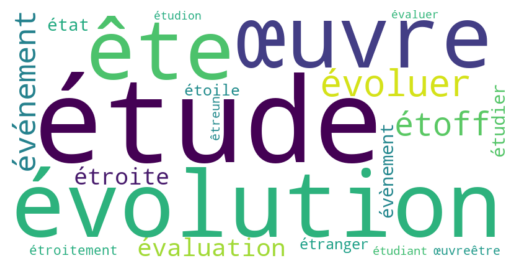

In [138]:
generateWorldCloud(cube[cube["website"]=="welcometothejungle"],20)


In [139]:
def getMostUsedWord(cube):
    if cube.shape[0] > 0 :
        line_frequencies = [json.loads(item) for item in cube["nb_occurences"]]
        total_frequencies = getTotalFrequencies(line_frequencies)
        mostUsedWord = sorted(total_frequencies, key=total_frequencies.get, reverse=True)[:1]
        mostUsedWord = {mostUsedWord[0]: total_frequencies[mostUsedWord[0]]}
        return mostUsedWord

In [ ]:
# def showUsedWordEvolution():
#     level=2
#     level_label = "published_year" if level==1 else ("published_month" if level==2 else ("day" if level==3 else "NONE"))
#     mostUsedDictWebsite = dict()
#     for website in cube["website"].unique():
#         mostUsedDictWebsite[str(website)] = {}
#         for item in cube[level_label].unique():
#             mostUsedDictWebsite[str(website)][str(item)] = getMostUsedWord(cube[(cube["website"]==website) & (cube[level_label] == item)])
#     return mostUsedDictWebsite


    

In [146]:
import plotly.graph_objects as go
from IPython.display import display
import calendar
import locale
#Il faut gérer les différents niveaux de détail
def showUsedWordEvolution():
    fig = go.Figure()
    mostUsed = dict()
    for item in cube["published_year"].unique():
        mostUsed[str(item)] = getMostUsedWord(cube[(cube["published_year"]==item)])

    sorted_mostUsed = dict(sorted(mostUsed.items()))
    # Extract keys and values for plotting
    x_year = sorted(sorted_mostUsed.keys(), key=lambda x: int(x))   
    locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')
    # x_year = [calendar.month_name[int(item)].capitalize() for item in x_year]
    values = {key: value for month_dict in sorted_mostUsed.values() for key, value in month_dict.items()}
    labels = list(values.keys())

    y_tfxidf = list(values.values())

    fig.add_trace(go.Scatter(x=x_year, y=y_tfxidf, mode='markers+lines', name='Frequencies'))
        
    for label, x, y in zip(labels, x_year, y_tfxidf):
        fig.add_annotation(
            go.layout.Annotation(
                x=x_year.index(x),
                y=y,
                text=label,
                showarrow=False,
                xanchor='center',
                yanchor='bottom'
            )
        )

    # Update layout
    fig.update_layout(title='TFxIDF par Jour',
                      xaxis=dict(title='Jour'),
                      yaxis=dict(title='TFxIDF'))
    return fig


In [147]:
showUsedWordEvolution()